# **Decision Trees**

They are versatile machine learning algorithms that can perform both classification and regression tasks and even multioutput tasks. They are capable of fitting complex datasets

Decision trees are also the fundamental components of Random Forests which are among the most powerful machine learning algorithms available today

We start by training, visualing and making predictions with Decision Trees. Then go through the CART training algorithm used by Scikit-Learn and discuss how to regularise trees and use them for regression tasks

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## **Training and Visualising Decision Trees**

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [5]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

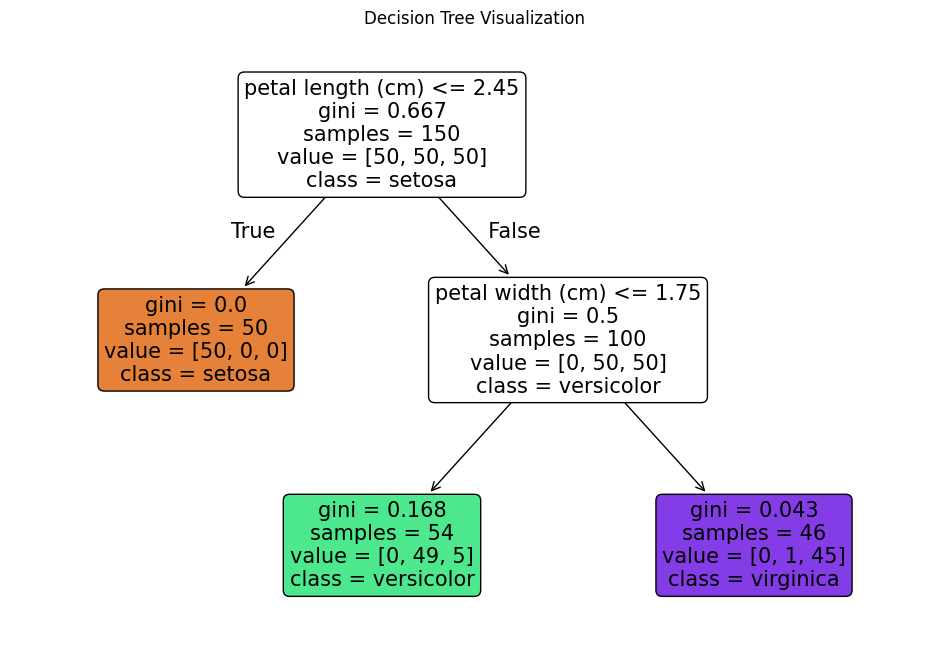

In [14]:
# Alternative visualization using matplotlib (no Graphviz installation required)
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(tree_clf, 
          feature_names=iris.feature_names[2:], 
          class_names=iris.target_names,
          filled=True, 
          rounded=True,
          fontsize=15)
plt.title("Decision Tree Visualization")
plt.show()

# Note: If you want to use the original graphviz visualization, you need to install Graphviz:
# On macOS: brew install graphviz
# On Ubuntu/Debian: sudo apt-get install graphviz
# On Windows: Download from https://graphviz.org/download/
# 
# Then uncomment the lines below:
# from graphviz import Source
# dot_file_path = os.path.join(IMAGES_PATH, "iris_tree.dot")
# src = Source.from_file(dot_file_path)
# src

## **Making Predictions**

Suppose you find an iris flower and you want to classify it. You start at the *root node* : this node asks whether flower's petal length is smaller than 2.45 cm. If it is then you move down to the root's left child node or other wise called *leaf node*

Now suppose you find another flower which has petal length greater than 2.45 cm, you must move down to the root's right child node, which is not a leaf node, so node asks another question

A node's attribute value tells you ho wmany training instances of each class this node applies to

Finally a node's gini attribute measures its impurity : a node is "pure" (gini = 0) if all training instances it applies to belong to the samel class

Saving figure decision_tree_decision_boundaries_plot


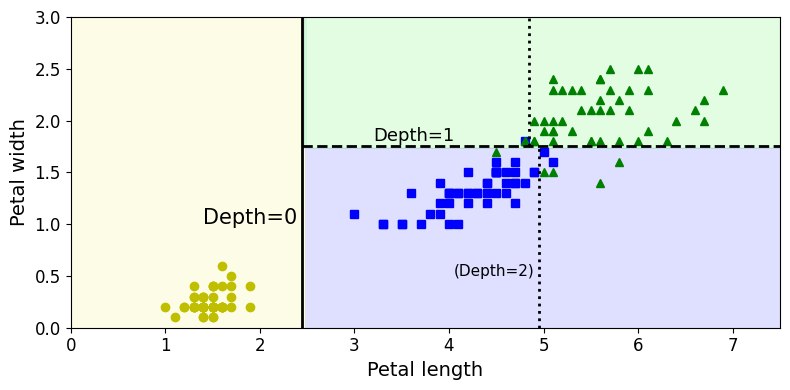

In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

This graph shows the Decision Tree's decision boundaries. The think vertical line represents the decision boundary of root node. Since letfthand area is pure, it cannot be split further but the right hand side area is impure so can be split further

Decision Trees are intuitive and their decisions are easy to interpret. Such models are called *white box models*. In contrast, Random Forests or neural networks are generally considered *black box mdoels*, you can easily check caluclations that they performed but it is usually hard to explain why the predictions were made

## **Estimating Class Probabilities**

A Decision Tree can also estimate the probabilities that an instance belongs to a prticular class k. First it traverses the tree to find the leaf node and then it returns the ratio of training instances of class k in this node

In [16]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [17]:
tree_clf.predict([[5, 1.5]])

array([1])

## **The CART Training Algorithm**

Scikit-Learn uses *Classification and Regression Tree* (CART) algorithm to train Decision Trees. The algorithm works by first splitting the training set into two subsets using a single feature k and a threshold t_k

It chooses k and t_k by searching for the pair of those values that produces the purest subsets (weighted by their size)

Afterwards, it splits the subsets using same logic, then the sub-subsets and so on, recursively. it stops recursing once it reaches the maximum depth or if cannot find a split that will reduce impurity

## **Regularization Hyperparameters**

Decision Trees make very few assumptions about the training data. If left unconstrained the tree structure will adapt itself to the data, fitting or often oevr-fitting to the training set

That is known as a *nonparametric model* where the number of parameeters is not determined prior to the training. In constrast, the *parametric model* has a pre-determined number of parameters so its degree of freedom is limited

In [18]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,40
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Saving figure decision_tree_instability_plot


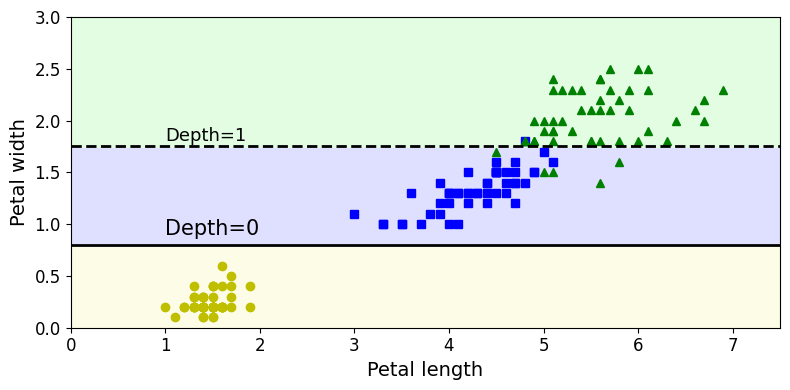

In [19]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()